### 7FNCE041W - Coursework
### Data Import via yfinance

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as si
import yfinance as yf
import mibian as mb
from mpl_toolkits.mplot3d import Axes3D

In [95]:
data = yf.download("EBAY", start="2020-03-01", end="2021-03-02")

[*********************100%***********************]  1 of 1 completed


In [96]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-03-02,34.619999,35.970001,34.279999,35.959999,35.500446,13131000
2020-03-03,35.730000,37.419998,35.660000,36.720001,36.250732,18838700
2020-03-04,37.320000,38.540001,37.139999,38.490002,37.998116,13445400
2020-03-05,37.480000,38.220001,37.070000,37.220001,36.744343,11816600
2020-03-06,35.709999,36.790001,35.590000,36.389999,35.924953,12849800


In [97]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-23,60.680000,61.730000,59.820000,61.369999,61.176132,5826500
2021-02-24,60.990002,61.049999,58.830002,59.380001,59.192421,8050000
2021-02-25,59.400002,59.970001,56.849998,56.980000,56.799999,7868300
2021-02-26,57.340000,57.660000,56.250000,56.419998,56.419998,9013500
2021-03-01,57.099998,58.700001,56.529999,58.480000,58.480000,6153700


### Adj Close

In [98]:
ADJ = data['Adj Close']

In [99]:
ADJ

Date
2020-03-02    35.500446
2020-03-03    36.250732
2020-03-04    37.998116
2020-03-05    36.744343
2020-03-06    35.924953
                ...    
2021-02-23    61.176132
2021-02-24    59.192421
2021-02-25    56.799999
2021-02-26    56.419998
2021-03-01    58.480000
Name: Adj Close, Length: 252, dtype: float64

Text(0, 0.5, 'Adj Close')

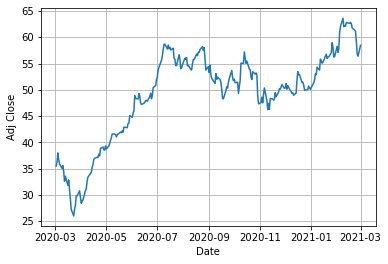

In [100]:
fig = plt.figure()
plt.plot( ADJ, '-')
plt.grid()
plt.xlabel('Date')
plt.ylabel('Adj Close')

array([<AxesSubplot:xlabel='Date'>], dtype=object)

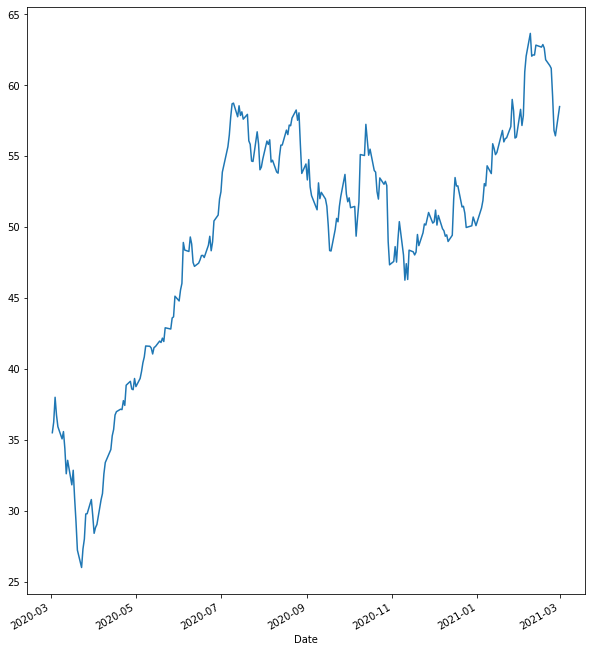

In [101]:
ADJ.plot(figsize=(10, 12), subplots=True)

### Summary Statistics

In [102]:
ADJ.describe().round(2)

count    252.00
mean      49.01
std        8.63
min       26.00
25%       45.04
50%       50.82
75%       55.30
max       63.64
Name: Adj Close, dtype: float64

### Annualised Volatility

In [103]:
log_return = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

In [104]:
vol = np.sqrt(252) * log_return.std()
print('The annualised volatility is', round(vol*100,2), '%')

The annualised volatility is 37.59 %


In [105]:
Sixlr = log_return[125:-1]

In [106]:
Sixlr

Date
2020-08-27   -0.039521
2020-08-28   -0.036900
2020-08-31    0.012306
2020-09-01   -0.020844
2020-09-02    0.026487
                ...   
2021-02-22   -0.006799
2021-02-23   -0.003091
2021-02-24   -0.032964
2021-02-25   -0.041257
2021-02-26   -0.006713
Name: Adj Close, Length: 126, dtype: float64

In [107]:
Vol = np.sqrt(252) * Sixlr.std()
print('The annualised volatility is', round(vol*50,2), '%')

The annualised volatility is 18.8 %


### Cash-or Nothing-Binary Option

Binary Call

In [108]:
cp = (S[-1,:]  - K)>0
bpc = np.mean(np.maximum(cp.astype(int),0))
print('Binary call', str(bpc))

Binary call 0.0


Binary Put

In [109]:
pp = (K - S[-1,:])>0
bpp = np.mean(np.maximum(pp.astype(int),0))
print('Binary put', str(bpp))

Binary put 1.0


bpc+bpp

In [110]:
bpc + bpp

1.0

### Binominal Tree (CRR Tree)

In [292]:
S0 = data['Adj Close'][-1]      # spot stock price      
K = 100                         # strike
T = 3/12                        # maturity 
r = 0.0167                      # risk free rate 
sig = 0.4                       # diffusion coefficient or volatility
N = 3                           # number of periods or number of time steps 
payoff = "put"                  # payoff

In [293]:
vol = np.sqrt(252) * log_return.std() 
vol

0.3759084055418103

In [294]:
dT = float(T) / N                             # Delta t
u = np.exp(sig * np.sqrt(dT))                 # up factor
d = 1.0 / u                                   # down factor

In [295]:
S = np.zeros((N + 1, N + 1))
S[0, 0] = S0
z = 1
for t in range(1, N + 1):
    for i in range(z):
        S[i, t] = S[i, t-1] * u
        S[i+1, t] = S[i, t-1] * d
    z += 1

In [296]:
S

array([[58.47999954, 65.63800426, 73.67215522, 82.6896935 ],
       [ 0.        , 52.10259491, 58.47999954, 65.63800426],
       [ 0.        ,  0.        , 46.42066377, 52.10259491],
       [ 0.        ,  0.        ,  0.        , 41.35836283]])

Tree for the underlying asset price distribution. Week 1. Put option.

In [297]:
a = np.exp(r * dT)    # risk free compound return
p = (a - d)/ (u - d)  # risk neutral up probability
q = 1.0 - p           # risk neutral down probability
p

0.4771814275585755

In [298]:
S_T = S[:,-1]
S_T

array([82.6896935 , 65.63800426, 52.10259491, 41.35836283])

In [299]:
V = np.zeros((N + 1, N + 1))
if payoff =="call":
    V[:,-1] = np.maximum(S_T-K, 0.0)
elif payoff =="put":
    V[:,-1] = np.maximum(K-S_T, 0.0)
V

array([[ 0.        ,  0.        ,  0.        , 17.3103065 ],
       [ 0.        ,  0.        ,  0.        , 34.36199574],
       [ 0.        ,  0.        ,  0.        , 47.89740509],
       [ 0.        ,  0.        ,  0.        , 58.64163717]])

### Monte Carlo Simulation

In [300]:
def mcs_simulation_np(p):
    M = p
    I = p
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rn[t]) 
    return S

In [301]:
T = 3/12
r = 0.0167
sigma = np.sqrt(252) * log_return.std() 
sigma
S0 = data['Adj Close'][-1]
K = 100

In [302]:
S0 = data['Adj Close'][-1]
S0

58.47999954223633

In [303]:
sigma = np.sqrt(252) * log_return.std() 
sigma

0.3759084055418103

Simulated 100 times for the asset price with 90 steps in three months.

In [304]:
S = mcs_simulation_np(100)

In [305]:
S = np.transpose(S)
S

array([[58.47999954, 56.08101955, 56.83029361, ..., 45.45284884,
        46.43355333, 46.21420607],
       [58.47999954, 57.90469008, 57.19719187, ..., 51.08371573,
        52.71259465, 53.84092919],
       [58.47999954, 60.02590183, 60.27633426, ..., 63.11746722,
        65.35924234, 67.4016437 ],
       ...,
       [58.47999954, 58.33099772, 59.39228834, ..., 60.34637614,
        57.58890659, 56.55649202],
       [58.47999954, 58.43820137, 56.04373043, ..., 39.10624731,
        40.01952997, 39.42568743],
       [58.47999954, 57.48549793, 58.07622227, ..., 66.1189044 ,
        66.80338129, 66.27356043]])

Histogram for S_T

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-preiod values')

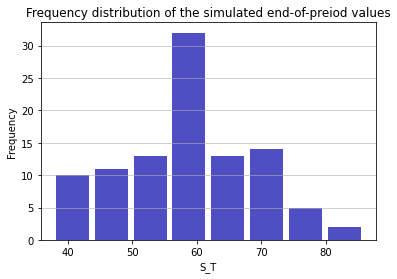

In [306]:
n, bins, patches = plt.hist(x=S[:,-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-preiod values')

### Greeks

In [307]:
def delta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        delta = np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0)
    elif payoff == "put":
        delta =  - np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0)
    
    return delta

In [308]:
delta(58.48, 100, 3/12, 0.4, 0.121, 0.37, 'call')

0.007316504923257611

In [309]:
delta(58.48, 100, 3/12, 0.4, 0.121, 0.37, 'put')

-0.9628864475657594

In [317]:
S = np.linspace(58.48,158.48,11)
Delta_Call = np.zeros((len(S),1))
Delta_Put = np.zeros((len(S),1))
for i in range(len(S)):
    Delta_Call [i] = delta(S[i], 100, 3/12, 0.4, 0.121, 0.37, 'call')
    Delta_Put [i] = delta(S[i], 100, 3/12, 0.4, 0.121, 0.37, 'put')

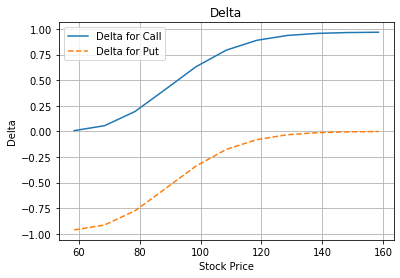

In [318]:
fig = plt.figure()
plt.plot(S, Delta_Call, '-')
plt.plot(S, Delta_Put, '--')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Delta')
plt.title('Delta')
plt.legend(['Delta for Call','Delta for Put'])

### Surface of Gamma

In [319]:
def gamma(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(-r * T) * si.norm.pdf(d1, 0.0, 1.0) / (vol * S * T)
    
    return gamma

In [320]:
gamma(58.48, 100, 3/12, 0.4, 0.121, 0.37, 'call')

0.0034808319202040278

In [321]:
gamma(58.48, 100, 3/12, 0.4, 0.121, 0.37, 'put')

0.0034808319202040278

In [322]:
S = np.linspace(58.48,158.48,11)
Gamma = np.zeros((len(S),1))
for i in range(len(S)):
    Gamma [i] = gamma(S[i], 100, 3/12, 0.4, 0.121, 0.37, 'call')

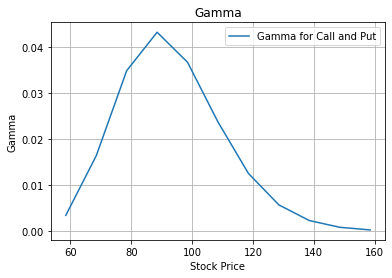

In [323]:
fig = plt.figure()
plt.plot(S, Gamma, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Gamma')
plt.title('Gamma')
plt.legend(['Gamma for Call and Put'])

### Surface of Speed

In [325]:
def speed(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    speed = np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / ((vol **2) * (S**2) * T) * (d1 + vol * np.sqrt(T))
    
    return speed

In [326]:
speed(58.48, 100, 3/12, 0.4, 0.121, 0.37, 'call')

-0.00038730985039928405

In [327]:
speed(58.48, 100, 3/12, 0.4, 0.121, 0.37, 'put')

-0.00038730985039928405

In [328]:
S = np.linspace(58.48,158.48,11)
Speed = np.zeros((len(S),1))
for i in range(len(S)):
    Speed [i] = speed(S[i], 100, 3/12, 0.4, 0.121, 0.37, 'call')

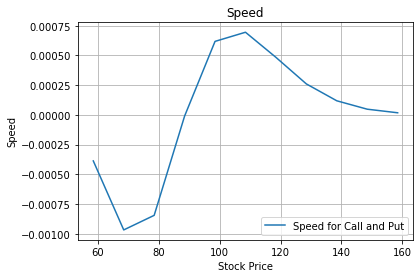

In [329]:
fig = plt.figure()
plt.plot(S, Speed, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Speed')
plt.title('Speed')
plt.legend(['Speed for Call and Put'])

### Surface of Theta

In [181]:
def theta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        theta = - vol * S * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / (2 * T) + q * S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        theta = - vol * S * np.exp(-q * T) * si.norm.pdf(-d1, 0.0, 1.0) / (2 * T) + q * S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) - r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [330]:
theta(58.48, 100, 3/12, 0.4, 0.121, 0.37, 'call')

-0.983216272034406

In [331]:
theta(58.48, 100, 3/12, 0.4, 0.121, 0.37, 'put')

-30.092450514132278

In [332]:
T = np.linspace(0.25,3,12)
Theta_Call = np.zeros((len(T),1))
Theta_Put = np.zeros((len(T),1))
for i in range(len(T)):
    Theta_Call [i] = theta(58.48, 100, T[i], 0.4, 0.121, 0.37, 'call')
    Theta_Put [i] = theta(58.48, 100, T[i], 0.4, 0.121, 0.37, 'put')

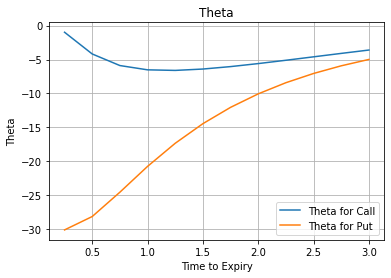

In [333]:
fig = plt.figure()
plt.plot(T, Theta_Call, '-')
plt.plot(T, Theta_Put, '-')
plt.grid()
plt.xlabel('Time to Expiry')
plt.ylabel('Theta')
plt.title('Theta')
plt.legend(['Theta for Call', 'Theta for Put'])

### Surface of Rho

In [182]:
def rho(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        rho =  K * T * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        rho = - K * T * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return rho

In [334]:
rho(58.48, 100, 3/12, 0.4, 0.121, 0.37, 'call')

0.10080409987711032

In [335]:
rho(58.48, 100, 3/12, 0.4, 0.121, 0.37, 'put')

-22.520131351021877

In [336]:
r = np.linspace(0,0.1,11)
Rho_Call = np.zeros((len(r),1))
Rho_Put = np.zeros((len(r),1))
for i in range(len(r)):
    Rho_Call [i] = rho(58.48, 100, 3/12, r[i], 0.121, 0.37, 'call')
    Rho_Put [i] = rho(58.48, 100, 3/12, r[i], 0.121, 0.37, 'put')

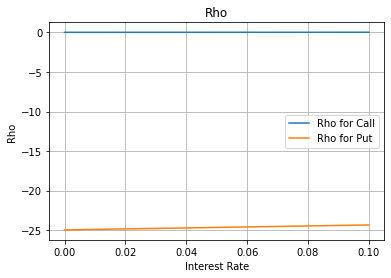

In [337]:
fig = plt.figure()
plt.plot(r, Rho_Call, '-')
plt.plot(r, Rho_Put, '-')
plt.grid()
plt.xlabel('Interest Rate')
plt.ylabel('Rho')
plt.title('Rho')
plt.legend(['Rho for Call', 'Rho for Put'])

### Surface Vega

In [196]:
def vega(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    vega = S * np.sqrt(T) * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0)
    
    return vega

In [338]:
vega(58.48, 100, 3/12, 0.4, 0.121, 0.37, 'call')

0.5903391124245906

In [339]:
vega(58.48, 100, 3/12, 0.4, 0.121, 0.37, 'put')

0.5903391124245906

In [340]:
vol = np.linspace(0.1,0.4,13)
Vega = np.zeros((len(vol),1))
for i in range(len(vol)):
    Vega [i] = vega(58.48, 100, 3/12, 0.4, 0.121, vol[i], 'call')

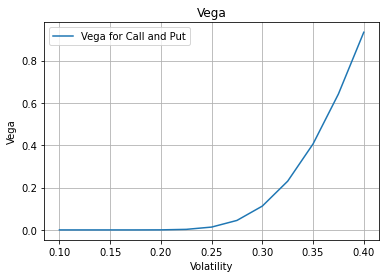

In [341]:
fig = plt.figure()
plt.plot(vol, Vega, '-')
plt.grid()
plt.xlabel('Volatility')
plt.ylabel('Vega')
plt.title('Vega')
plt.legend(['Vega for Call and Put'])